In [ ]:
from google.colab import drive
import zipfile
import os
from os import listdir, path
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline
from matplotlib import pyplot
from wordcloud import WordCloud
from sklearn import preprocessing
import keras
from keras.layers import Conv2D, Input, MaxPooling2D, Flatten, Dense, Reshape

In [ ]:
ROOT_DIR = '/tmp/valid'
image_size = (224,224)    #tamanho das imagens do resnet

sum = 0
sum2 = 0
i = 0

images = []
labels = []
species = []
plants_df = []
categs_df = []
all_paths = []
all_labels = []
labels_for_enc = []
all_labels_tog = []
all_species = []
ex_images = []

encode = {}

#Replace Image Names

This code is used to change the names of the images inside each file so the data is more organized and every image has a corresponding label.
These lines can't be used here so we used spyder.
For every file the code needs to be altered but this is the basis to be used. In this case it changes the names of the images inside the file "Apple Scab" and each image will have the name "Apple Scab *n*", where *n* is a number starting from zero.

In [ ]:
#import os
#def main():
   #folder = "D:/Dataset/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab"
   #for count, filename in enumerate(os.listdir(folder)):
     #dst = f"Apple_scab {str(count)}.jpg"
     #src = f"{folder}/{filename}"  # foldername/filename, if .py file is outside folder
     #dst = f"{folder}/{dst}"
     #os.rename(src, dst)
 
#if __name__ == '__main__':
     #main()

# Data Extraction

The first step is to load the dataset into Colab. For that we have the whole dataset in a GoogleDrive file.
First we authorize Colab to reach our GoogleDrive.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Then we specify where the file is in our GoogleDrive and extract the files into a tmp file in Colab.

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/valid.zip', 'r') #no folder do notebook procurar o folder onde está o zip e copiar o caminho
zip_ref.extractall('/tmp')
zip_ref.close()

Lastly we can check the number of files in the tmp file, whose path is given by ROOT_DIR.

In [ ]:
len(os.listdir(ROOT_DIR))

38

#Exploratory Data Analysis 1

We decided to make a first Exploratory Data Analysis to see how the original data is presented. Here we can see the number of files that where loaded.

In [ ]:
plant_folders = listdir(ROOT_DIR)
print(plant_folders)
print(len(plant_folders))

['Cherry Powdery_Mildew', 'Tomato Yellow_Leaf_Curl_Virus', 'Cherry Healthy', 'Apple Healthy', 'Corn_Maize Common_Rust', 'Grape Black_Measles', 'Tomato Late_Blight', 'Pepper_Bell Healthy', 'Corn_Maize Gray_Leaf_Spot', 'Strawberry Leaf_Scorch', 'Blueberry Healthy', 'Potato Early_Blight', 'Tomato Septoria_Leaf_Spot', 'Apple Cedar_Rust', 'Apple Black_Rot', 'Soybean Healthy', 'Squash Powdery_Mildew', 'Grape healthy', 'Tomato Target_Spot', 'Raspberry Healthy', 'Tomato Bacterial_Spot', 'Tomato Healthy', 'Corn_Maize Northern_Leaf_Blight', 'Tomato Mosaic_Virus', 'Orange Greening', 'Corn_Maize Healthy', 'Potato Healthy', 'Potato Late_Blight', 'Grape Black_Rot', 'Pepper_Bell Bacterial_Spot', 'Peach Bacterial_Spot', 'Grape Isariopsis_Leaf_Spot', 'Apple Scab', 'Peach Healthy', 'Tomato Leaf_Mold', 'Tomato Two_Spotted_Spider_Mite', 'Strawberry Healthy', 'Tomato Early_Blight']
38


Then we can visualize the ammount of data that we have through a dataframe. This one shows the number of images in each file.

In [ ]:
num_pic = []
for folder in plant_folders:
    plant_list = listdir(path.join(ROOT_DIR,folder))
    num_pic.append(len(plant_list))

df_plants = pd.DataFrame({"folder":plant_folders,"num_pic":num_pic})
df_plants

,folder,num_pic
0,Cherry Powdery_Mildew,421
1,Tomato Yellow_Leaf_Curl_Virus,490
2,Cherry Healthy,456
3,Apple Healthy,502
4,Corn_Maize Common_Rust,477
5,Grape Black_Measles,480
6,Tomato Late_Blight,463
7,Pepper_Bell Healthy,497
8,Corn_Maize Gray_Leaf_Spot,410
9,Strawberry Leaf_Scorch,444


We can also group the plants available and see how many labels there are for each with another dataframe.

In [ ]:
for plant in plant_folders:
  plants_df.append(plant.split(' ')[0])
  categs_df.append(plant.split(' ')[1])

df_plants2 = pd.DataFrame({"plant":plants_df, 'label':categs_df, "num_pic":num_pic})
df_plants2.groupby(by=['plant','label'], sort=True).sum()

num_pic
plant       label                           
Apple       Black_Rot                    497
            Cedar_Rust                   440
            Healthy                      502
            Scab                         504
Blueberry   Healthy                      454
Cherry      Healthy                      456
            Powdery_Mildew               421
Corn_Maize  Common_Rust                  477
            Gray_Leaf_Spot               410
            Healthy                      465
            Northern_Leaf_Blight         477
Grape       Black_Measles                480
            Black_Rot                    472
            Isariopsis_Leaf_Spot         430
            healthy                      423
Orange      Greening                     503
Peach       Bacterial_Spot               459
            Healthy                      432
Pepper_Bell Bacterial_Spot               478
            Healthy                      497
Potato      Early_Blight                 485
            Healthy                      456
            Late_Blight                  485
Raspberry   Healthy                      445
Soybean     Healthy                      505
Squash      Powdery_Mildew               434
Strawberry  Healthy                      456
            Leaf_Scorch                  444
Tomato      Bacterial_Spot               425
            Early_Blight                 480
            Healthy                      481
            Late_Blight                  463
            Leaf_Mold                    470
            Mosaic_Virus                 448
            Septoria_Leaf_Spot           436
            Target_Spot                  457
            Two_Spotted_Spider_Mite      435
            Yellow_Leaf_Curl_Virus       490

It's also possible to see just the number of images for each plant without discrimminating their categories in a third dataframe

In [ ]:
df_plants3 = df_plants2.groupby(by='plant', sort=True).sum()
df_plants3

,num_pic
plant,
Apple,1943
Blueberry,454
Cherry,877
Corn_Maize,1829
Grape,1805
Orange,503
Peach,891
Pepper_Bell,975
Potato,1426


Lastly we can check the amount of diseases that we have in our data without dividing the images along the plants.

In [ ]:
df_plants4 = df_plants2.groupby(by='label', sort=True).sum()
df_plants4

,num_pic
label,
Bacterial_Spot,1362
Black_Measles,480
Black_Rot,969
Cedar_Rust,440
Common_Rust,477
Early_Blight,965
Gray_Leaf_Spot,410
Greening,503
Healthy,5149


#Data Treatment

Here we created two lists of lists (all_paths and all_labels) that have the paths for all the images and their corresponding labels.
These are organized so that every list inside the main list corresponds only to one label.

In [ ]:
for folder in plant_folders:
    plant_list_path = listdir(path.join(ROOT_DIR,folder))
    img_paths = []
    labels = []
    species = []

    for img_dir in plant_list_path:
      img_path = path.join(ROOT_DIR, folder, img_dir)
      img_paths.append(img_path)             #list of paths for all images of that folder; list will later be used for all_paths; [path_image1, path_image2, path_image3, path_image4]

      specie = img_dir.split(' ')[0]         #specie of that image; 'tomato', 'blueberry', etc 
      label = img_dir.split(' ')[1]          #label of that image; 'black_rot', 'late_blight', 'healthy', etc
      labels.append(label.lower())           #list of labels for all images of that folder; list will later be used for all_labels; [label1, label1, label1, label1, label1]
      species.append(specie)


    labels_for_enc.append(label.lower())     #list of all labels that will later be used to create an encoder
    all_paths.append(img_paths)              #list of lists with the paths of each image; each list has a collection of the paths of all images for one of the 38 folders; 38 lists inside one list; each list inside has different lengths; [[path_image1_label1, path_image2_label1, path_image3_label1], [path_image1_label2, path_image2_label2, path_image3_label2], [path_image1_label3, path_image2_label3, path_image3_label3]]
    all_species += species
    all_labels_tog += labels
    all_labels.append(labels)                #list of lists with the labels of each image; each list has a collection of the labels of all images for one of the 38 folders; 38 lists inside one list; each list inside has different lengths; [[label1_image1, label1_image2, label1_image3], [label2_image1, label2_image2, label2_image3], [label3_image1, label3_image2, label3_image3]]

Now we can see how many paths (therefore images) we have for each label.

We will then have 38 lines, corresponding to each folder and in each we can see how many images there are.

We can also see the total of paths that we have, given by sum.

In [ ]:
for pth in all_paths:
  sum += len(pth)
  print(len(pth))
print('sum is: ', sum)

len of the path is: 421
len of the path is: 490
len of the path is: 456
len of the path is: 502
len of the path is: 477
len of the path is: 480
len of the path is: 463
len of the path is: 497
len of the path is: 410
len of the path is: 444
len of the path is: 454
len of the path is: 485
len of the path is: 436
len of the path is: 440
len of the path is: 497
len of the path is: 505
len of the path is: 434
len of the path is: 423
len of the path is: 457
len of the path is: 445
len of the path is: 425
len of the path is: 481
len of the path is: 477
len of the path is: 448
len of the path is: 503
len of the path is: 465
len of the path is: 456
len of the path is: 485
len of the path is: 472
len of the path is: 478
len of the path is: 459
len of the path is: 430
len of the path is: 504
len of the path is: 432
len of the path is: 470
len of the path is: 435
len of the path is: 456
len of the path is: 480
sum is:  35144


We can do the same for the labels.

Here we can check that the number of labels is the same as the paths for each folder and for the total (sum).

In [ ]:
for lbl in all_labels:
  sum2 += len(lbl)
  print(len(lbl))
print('sum is: ', sum2)

421
490
456
502
477
480
463
497
410
444
454
485
436
440
497
505
434
423
457
445
425
481
477
448
503
465
456
485
472
478
459
430
504
432
470
435
456
480
sum is:  17572


We can see the format of one of the positions inside one of the lists of all_paths.

In [ ]:
all_paths[16][200]

'/tmp/valid/Squash Powdery_Mildew/Squash Powdery_Mildew 125.jpg'

Because in each path we also have the label in the name, if we see the same position but this time in all_labels, we can check that these correspond to the same.

In [ ]:
all_labels[16][200]

'powdery_mildew'

Now we can evaluate the labels_for_enc list. This list will now help us to transform our labels from strings ('healthy', 'late_blight', 'mosaic_virus', etc) into intergers (0, 1, 2, etc).

First we can see all of the labels inside the list.

In [ ]:
labels_for_enc

['powdery_mildew',
 'yellow_leaf_curl_virus',
 'healthy',
 'healthy',
 'common_rust',
 'black_measles',
 'late_blight',
 'healthy',
 'gray_leaf_spot',
 'leaf_scorch',
 'healthy',
 'early_blight',
 'septoria_leaf_spot',
 'cedar_rust',
 'black_rot',
 'healthy',
 'powdery_mildew',
 'healthy',
 'target_spot',
 'healthy',
 'bacterial_spot',
 'healthy',
 'northern_leaf_blight',
 'mosaic_virus',
 'greening',
 'healthy',
 'healthy',
 'late_blight',
 'black_rot',
 'bacterial_spot',
 'bacterial_spot',
 'isariopsis_leaf_spot',
 'scab',
 'healthy',
 'leaf_mold',
 'two_spotted_spider_mite',
 'healthy',
 'early_blight']

We can also see how many labels there are. There should be the same as the number of folders that our data was organized into.

In [ ]:
len(labels_for_enc)

38

Now we can create a dictionary for these labels. The keys are the labels and the corresponding value is the atributted interger.

If the label already exists (because some diseases repeat over the plants, and for each we have a healthy folder), the number will only be updated.  

In [ ]:
labels_for_enc = np.unique(labels_for_enc)

In [ ]:
labels_for_enc

array(['bacterial_spot', 'black_measles', 'black_rot', 'cedar_rust',
       'common_rust', 'early_blight', 'gray_leaf_spot', 'greening',
       'healthy', 'isariopsis_leaf_spot', 'late_blight', 'leaf_mold',
       'leaf_scorch', 'mosaic_virus', 'northern_leaf_blight',
       'powdery_mildew', 'scab', 'septoria_leaf_spot', 'target_spot',
       'two_spotted_spider_mite', 'yellow_leaf_curl_virus'], dtype='<U23')

In [ ]:
for i, label in enumerate(labels_for_enc):
  encode[label] =  i

encode

{'bacterial_spot': 0,
 'black_measles': 1,
 'black_rot': 2,
 'cedar_rust': 3,
 'common_rust': 4,
 'early_blight': 5,
 'gray_leaf_spot': 6,
 'greening': 7,
 'healthy': 8,
 'isariopsis_leaf_spot': 9,
 'late_blight': 10,
 'leaf_mold': 11,
 'leaf_scorch': 12,
 'mosaic_virus': 13,
 'northern_leaf_blight': 14,
 'powdery_mildew': 15,
 'scab': 16,
 'septoria_leaf_spot': 17,
 'target_spot': 18,
 'two_spotted_spider_mite': 19,
 'yellow_leaf_curl_virus': 20}

In [ ]:
len(labels_for_enc)

21

Due to problems of running out of RAM available to us, we had to create batches to divide our data. Here we divided the data into 10 batches.

So we created two dictionaries, one for the paths of the images and one for the labels.

For each dictionary, the keys are the name of the batch (batch_1, batch_2, batch_3, etc) and the values correspond to the paths/label.

In [ ]:
num_batchs = 10
bts_paths = {}
bts_labels = {}

for i in range(1,num_batchs+1):
  word = f"batch_{i}"
  bts_paths[word] = []
  bts_labels[word] = []

print(bts_paths)
print(bts_labels)

{'batch_1': [], 'batch_2': [], 'batch_3': [], 'batch_4': [], 'batch_5': [], 'batch_6': [], 'batch_7': [], 'batch_8': [], 'batch_9': [], 'batch_10': []}
{'batch_1': [], 'batch_2': [], 'batch_3': [], 'batch_4': [], 'batch_5': [], 'batch_6': [], 'batch_7': [], 'batch_8': [], 'batch_9': [], 'batch_10': []}



For this we had to take into account that our data is organized, which means that the paths/labels are grouped. Therefore, we had to divide the data into the batches, so that each batch has aproximatelly 10% of each category.

We start with the dictionay for the paths.

In [ ]:
i = 0
for list_paths in all_paths:
  divided_list = [list(array) for array in np.array_split(np.array(list_paths), num_batchs)]
  for part in divided_list:
    bts_paths[list(bts_paths.keys())[i]] += part
    i+=1
  i=0

Now we can see the shape of the dictionary. We can check that for each key (batch) there are aproxitamelly the same number of paths.

In [ ]:
for b_path in list(bts_paths.keys()):
  print(b_path,len(bts_paths[b_path]))

batch_1 1773
batch_2 1771
batch_3 1768
batch_4 1765
batch_5 1761
batch_6 1754
batch_7 1750
batch_8 1745
batch_9 1743
batch_10 1742


Now we can do the same for the labels. Here we also encoded our labels by using the dictionary previosly created.

In [ ]:
for label in all_labels:
  divided_list = [list(array) for array in np.array_split(np.array(label), num_batchs)]
  for part in divided_list:
    encoded_part = []
    for individual_label in part:
      encoded_label = encode[individual_label]
      encoded_part.append(encoded_label)
    bts_labels[list(bts_labels.keys())[i]] += encoded_part
    i+=1
  i=0

We can again see the number of labels in each key (batch) and check that they are the same as the dictionary of the paths.

In [ ]:
for b_label in list(bts_labels.keys()):
  print(b_label,len(bts_labels[b_label]))

batch_1 1773
batch_2 1771
batch_3 1768
batch_4 1765
batch_5 1761
batch_6 1754
batch_7 1750
batch_8 1745
batch_9 1743
batch_10 1742


For the same interval of values on the same bacth we can see the encoded label and the path of the image. By consulting the previously created dictionary for the encoding of the labels we can see that the number of the label is the same as the label that is contained in the name of the path of the image.
(aka 8 does correspond to healthy)

In [ ]:
bts_labels['batch_1'][500:510]

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

In [ ]:
bts_paths['batch_1'][500:510]

['/tmp/valid/Blueberry Healthy/Blueberry Healthy 323.jpg',
 '/tmp/valid/Blueberry Healthy/Blueberry Healthy 35.jpg',
 '/tmp/valid/Blueberry Healthy/Blueberry Healthy 355.jpg',
 '/tmp/valid/Blueberry Healthy/Blueberry Healthy 386.jpg',
 '/tmp/valid/Blueberry Healthy/Blueberry Healthy 127.jpg',
 '/tmp/valid/Blueberry Healthy/Blueberry Healthy 342.jpg',
 '/tmp/valid/Blueberry Healthy/Blueberry Healthy 30.jpg',
 '/tmp/valid/Blueberry Healthy/Blueberry Healthy 221.jpg',
 '/tmp/valid/Blueberry Healthy/Blueberry Healthy 118.jpg',
 '/tmp/valid/Blueberry Healthy/Blueberry Healthy 242.jpg']

# Exploratory Data Analysis 2


##See The Images

For our second Exploratory Data Analysis we can firstly analyze some of the images in our dataset.
Because we applied a random index, everytime the code is executed, we will see different images. This allows us to check the quality of them.
We concluded that there are images with different levels of brightness, some close-ups, etc.

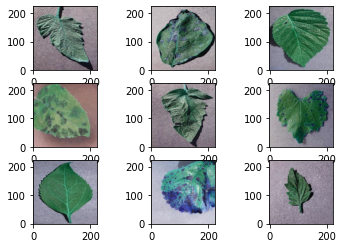

In [ ]:
ex_paths = bts_paths['batch_1']

for path in ex_paths:
  ex_image = cv2.imread(path)
  ex_image = cv2.resize(ex_image, image_size)
  ex_images.append(ex_image)

ex_images = np.asarray(ex_images, dtype=np.float32)
index = np.random.permutation(len(ex_images))[:9] 

for i in range(9):     
  pyplot.subplot(3,3,1+i)    
  pyplot.imshow(ex_images[index[i]]/256, origin = 'lower')
pyplot.show()

To better see the distribution of our data, a wordcloud containing the different types of plants was created.

##Word Clouds

In [ ]:
all_plants = ' '.join(all_species)
print(all_plants)

Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry Cherry

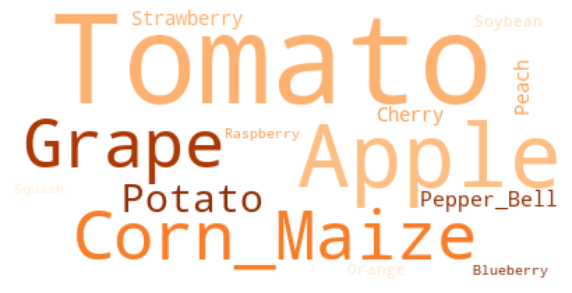

In [ ]:
wc_plants = WordCloud(background_color='white', collocations = False, colormap='Oranges')
wc_plants.generate(all_plants)
#wc.words_
pyplot.figure(figsize=(10,10))
pyplot.imshow(wc_plants, interpolation = 'bilinear')
pyplot.axis("off")
pyplot.show()

Additionally a wordcloud of the diseases was also created.

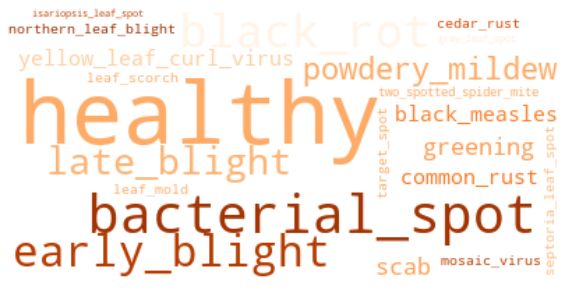

In [ ]:
all_labels = ' '.join(all_labels_tog)

wc_labels = WordCloud(background_color='white', collocations = False, colormap='Oranges')             
wc_labels.generate(all_labels)
wc_labels.words_

pyplot.figure(figsize=(10,10))
pyplot.imshow(wc_labels, interpolation = 'bilinear')
pyplot.axis("off")                                    
pyplot.show()